In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sys
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
from PIL import Image
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from numpy import asarray
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

DATA_DIR = '/content/drive/MyDrive/OCR/'
TEST_IMAGES_FILENAMES = DATA_DIR+'t10k-images.idx3-ubyte'
TEST_LABELS_FILENAMES = DATA_DIR+'t10k-labels.idx1-ubyte'
TRAIN_IMAGES_FILENAMES = DATA_DIR+'train-images.idx3-ubyte'
TRAIN_IMAGES_FILENAMES = DATA_DIR+'train-labels.idx1-ubyte'

In [ ]:
def bytes_to_int(bytes_data):
    return int.from_bytes(bytes_data , 'big')

In [ ]:
def read_images(file_name):
    images = []
    with open(file_name , 'rb') as fp:
        magic_number = bytes_to_int(fp.read(4))
        no_images = bytes_to_int(fp.read(4))
        no_rows = bytes_to_int(fp.read(4))
        no_columns = bytes_to_int(fp.read(4))
        for images_index in tqdm(range(no_images)):
            image = []
            for row_index in range(no_rows):
                row = []
                for col_index in range(no_columns):
                    pixels = fp.read(1)
                    row.append(pixels)
                image.append(row)
            images.append(image)
    return images

In [ ]:
def read_labels(file_name):
  labels = []
  with open(file_name , 'rb') as fp:
    magic_number = bytes_to_int(fp.read(4))
    no_labels = bytes_to_int(fp.read(4))
    for label_indx in range(no_labels):
      label = fp.read(1)
      labels.append(label)
  return labels

In [ ]:
Train_images = read_labels(TRAIN_IMAGES_FILENAMES)
print(len(Train_images))

60000


###IMPORTING TRAIN DATA###

In [ ]:
train_data = pd.read_csv(DATA_DIR+'mnist_train.csv')
train_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###IMPORTING **TEST** DATA###

In [ ]:
test_data = pd.read_csv(DATA_DIR+'mnist_test.csv')
test_data

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train = train_data.drop('label',axis = 1)
Y_train = train_data.iloc[:,0]

In [ ]:
X_train

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y_train

0        5
1        0
2        4
3        1
4        9
        ..
59995    8
59996    3
59997    5
59998    6
59999    8
Name: label, Length: 60000, dtype: int64

In [ ]:
X_test = test_data.drop('label',axis = 1)
Y_test = test_data.iloc[:,0]
print(X_test)
print(Y_test)

      1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  1x10  ...  28x19  28x20  \
0       0    0    0    0    0    0    0    0    0     0  ...      0      0   
1       0    0    0    0    0    0    0    0    0     0  ...      0      0   
2       0    0    0    0    0    0    0    0    0     0  ...      0      0   
3       0    0    0    0    0    0    0    0    0     0  ...      0      0   
4       0    0    0    0    0    0    0    0    0     0  ...      0      0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...    ...    ...   
9995    0    0    0    0    0    0    0    0    0     0  ...      0      0   
9996    0    0    0    0    0    0    0    0    0     0  ...      0      0   
9997    0    0    0    0    0    0    0    0    0     0  ...      0      0   
9998    0    0    0    0    0    0    0    0    0     0  ...      0      0   
9999    0    0    0    0    0    0    0    0    0     0  ...      0      0   

      28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  


#DISTRIBUTION OF TRAIN DATA#

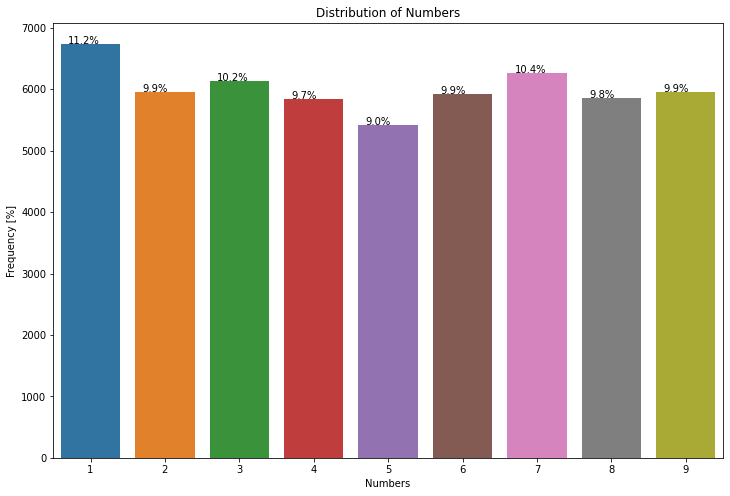

In [ ]:
plt.figure(figsize=(12,8))
total = 60000
ax = sns.countplot(x = "label",data=train_data,order=[1,2,3,4,5,6,7,8,9])
plt.title('Distribution of Numbers')
plt.xlabel('Numbers')
plt.ylabel('Frequency [%]')
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#DISTIBUTION OF TEST DATA

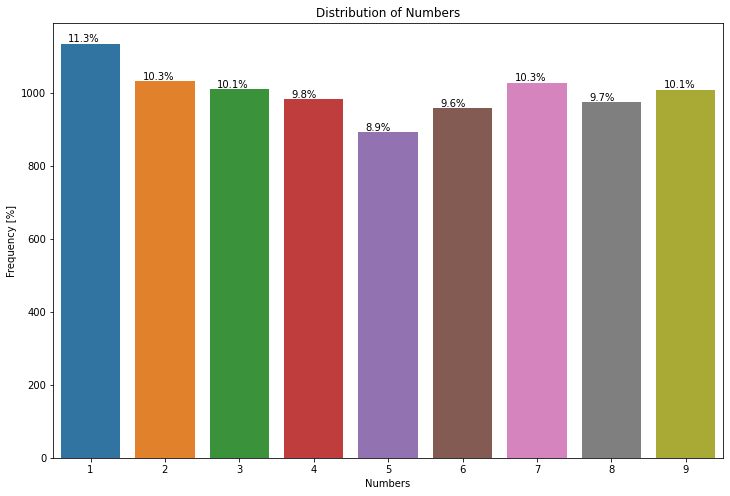

In [ ]:
plt.figure(figsize=(12,8))
total = 10000
ax = sns.countplot(x = "label",data=test_data,order=[1,2,3,4,5,6,7,8,9])
plt.title('Distribution of Numbers')
plt.xlabel('Numbers')
plt.ylabel('Frequency [%]')
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#DATA VISUALIZATION

> TRAIN SET



In [ ]:
Xtsne = TSNE(perplexity = 45,n_components=2, random_state=0)
results = Xtsne.fit_transform(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


KeyboardInterrupt: ignored

In [ ]:
compressed_data = results
compressed_data

array([[  4.17372656, -25.00736618,   5.        ],
       [-30.10431671, -17.31119728,   0.        ],
       [-34.03451538,  23.19059753,   4.        ],
       ...,
       [  4.99827957, -23.17804337,   5.        ],
       [-13.13562012, -32.36168289,   6.        ],
       [ 11.18324184,  11.90655994,   8.        ]])

In [ ]:
plt.figure(figsize=(12,8))
compressed_data = np.vstack((compressed_data.T, Y_train)).T
# tsne_df = pd.DataFrame(data=compressed_data, columns=("Dim_1","Dim_2","label"))
# # Ploting the result of tsne
# tsne_df
compressed_data

array([[  4.17372656, -25.00736618,   5.        ,   5.        ,
          5.        ],
       [-30.10431671, -17.31119728,   0.        ,   0.        ,
          0.        ],
       [-34.03451538,  23.19059753,   4.        ,   4.        ,
          4.        ],
       ...,
       [  4.99827957, -23.17804337,   5.        ,   5.        ,
          5.        ],
       [-13.13562012, -32.36168289,   6.        ,   6.        ,
          6.        ],
       [ 11.18324184,  11.90655994,   8.        ,   8.        ,
          8.        ]])

<Figure size 864x576 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


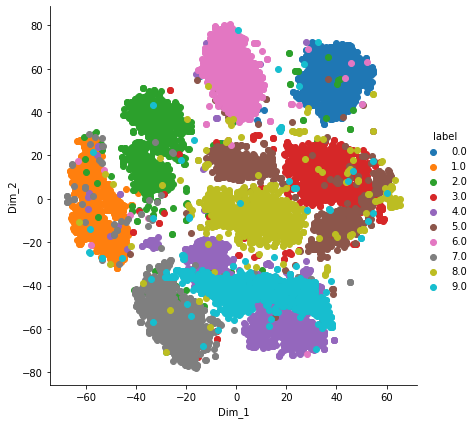

In [ ]:
sns.FacetGrid(tsne_df,hue="label",size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()



> TEST SET



In [ ]:
Xtsne_test = TSNE(random_state=0,perplexity = 30,n_components=2)
compressed_data_test = Xtsne.fit_transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
compressed_data_test_1 = compressed_data_test

In [ ]:
plt.figure(figsize=(12,8))
compressed_data_test_1 = np.vstack((compressed_data_test_1.T, Y_test)).T
tsne_df_1 = pd.DataFrame(data=compressed_data_test_1, columns=("Dim_1","Dim_2","label"))
tsne_df_1

,Dim_1,Dim_2,label
0,-29.864523,-56.223431,7.0
1,-39.850983,8.962563,2.0
2,-57.423920,0.402114,1.0
3,37.223118,42.123184,0.0
4,24.467558,-64.531036,4.0
...,...,...,...
9995,-30.040747,16.095057,2.0
9996,44.982777,16.336405,3.0
9997,-13.686232,-27.604309,4.0
9998,-5.505101,18.973530,5.0


<Figure size 864x576 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


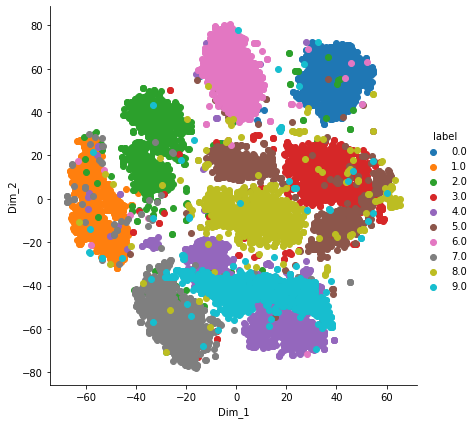

In [ ]:
sns.FacetGrid(tsne_df_1,hue="label",size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
X_tensor = tf.convert_to_tensor(X_train)
X_tensor

<tf.Tensor: shape=(60000, 784), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>

#PLOTTING IMAGES

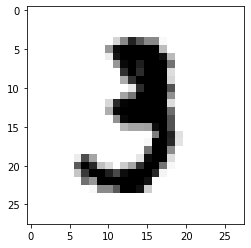

In [ ]:
image1 = X_tensor[10].numpy().reshape(28,28)
plt.imshow(image1,cmap='gray_r')

In [ ]:
X_train

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# KNN CLASSIFIER

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train,Y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = neigh.predict(X_test)
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
Y_test = Y_test.to_numpy()
Y_test

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_pred)
accuracy_score(Y_test, y_pred)

0.9705

In [ ]:
image = Image.open('3.png')
image_data = asarray(image)
columns = X_train.columns
# image_data = image_data.reshape(784)
# print(image_data)
# tsne_image = pd.DataFrame(np.atleast_2d(image_data),columns=columns)
# tsne_image
image_data

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

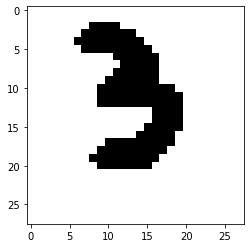

In [ ]:
image2 = plt.imshow(image_data.reshape(28,28),cmap = 'gray_r')

In [ ]:
pred = neigh.predict(tsne_image)
print(pred)

[1]


#RANDOM FOREST

In [ ]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,Y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, Y_train)
    predict_y = sig_clf.predict_proba(X_test)
    cv_log_error_array.append(log_loss(Y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,Y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, Y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_test, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y))